In [1]:
from calculating_risk_for_single_community import calculating_risk_for_single_community as single_calculate
import numpy as np
import pandas as pd
import math
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
Method
1) Daily new cases
2) Model outputs
    a) Aggregate RPI data to communities
    b) Unify the format
3) Convert to Value between -1,0,1
4) Calculate correlation coefficient
'''


'\nMethod\n1) Daily new cases\n2) Model outputs\n    a) Aggregate RPI data to communities\n    b) Unify the format\n3) Convert to Value between -1,0,1\n4) Calculate correlation coefficient\n'

In [4]:
# input data into dataframes
population = pd.read_csv('processed_population.csv')

url_infe = "https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19.csv"
infection = pd.read_csv(url_infe)

url_usc = "https://raw.githubusercontent.com/ANRGUSC/covid19_risk_estimation/master/data/Covid-19-R.csv"
risk_usc = pd.read_csv(url_usc)

url_rpi = "https://raw.githubusercontent.com/Yueyang-Li-Elfa/Risk-Score-RPI-Solver/master/Latest%20Risk%20Score/risk_score.csv"
risk_rpi = pd.read_csv(url_rpi)

url_umich1 = "https://raw.githubusercontent.com/skasralikar/Risk-Score-1-UMichZJU/master/data/output/LA-daily-out-08-18-2020.csv"
risk_umich1 = pd.read_csv(url_umich1,error_bad_lines=False)

# url_lmu = "https://raw.githubusercontent.com/wujj0326/COVID_Risk_Competition/master/Data/final_risk_score.csv"
# risk_lmu = pd.read_csv(url_lmu)

url_umich3 = "https://raw.githubusercontent.com/sli525/rmds-lab-team3-project/master/output%20file/risk_level.csv"
risk_umich3 = pd.read_csv(url_umich3)


In [5]:
# Change all regions/locations to Title Style
infection['Region'] = infection.apply(lambda x: x['Region'].replace('UNINCORPORATED - ','').title().replace('city of ',''), axis = 1)

print(population.head(),'\n',infection.head(),'\n',risk_usc.head(),'\n',risk_umich1.head(),'\n',risk_umich3.head())

            Region   Latitude   Longitude  Population
0       Northridge  34.234561 -118.536932       67755
1  Exposition Park  34.013654 -118.287211       45190
2          Norwalk  33.909280 -118.084917      104868
3        Hawthorne  33.918859 -118.348326      114032
4       El Segundo  33.917028 -118.415634       26864 
    Time Stamp         Region   Latitude   Longitude  Number of cases
0  03-16-2020       Alhambra  34.093042 -118.127060                2
1  03-16-2020        Arcadia  34.136208 -118.040150                1
2  03-16-2020  Beverly Hills  34.069650 -118.396306                1
3  03-16-2020  Boyle Heights  34.043689 -118.209768                5
4  03-16-2020         Carson  33.832204 -118.251755                1 
    Unnamed: 0  Time Stamp         Region   Latitude   Longitude  Risk-Score  \
0           0  03-16-2020       Alhambra  34.093042 -118.127060    0.158705   
1           1  03-16-2020        Arcadia  34.136208 -118.040150    0.142132   
2           2  03-16-

In [6]:
# Create a variable to save the latest start date and earlist end date
date_inter=["01-01-2020","12-31-2020"]
date_inter[0] = datetime.datetime.strptime(date_inter[0],'%m-%d-%Y')
date_inter[1] = datetime.datetime.strptime(date_inter[1],'%m-%d-%Y')

In [7]:
# Organize all model outputs to the format as ["Region","cases","risk","first_date","last_date"]
# USC
la_regions = risk_usc.Region.unique()

model_usc = pd.DataFrame()
model_usc["Region"] = la_regions
model_usc["cases"] = np.empty((len(model_usc), 0)).tolist()
model_usc["risk"] = np.empty((len(model_usc), 0)).tolist()
model_usc["first_date"] = np.empty((len(model_usc), 0)).tolist()
model_usc["last_date"] = np.empty((len(model_usc), 0)).tolist()

infection.sort_values(by="Time Stamp")
risk_usc.sort_values(by="Time Stamp")

for index, row in model_usc.iterrows():
    case_r = infection.loc[infection['Region'] == row["Region"]]
    risk_r = risk_usc.loc[risk_usc['Region'] == row["Region"]]
    model_usc["cases"][index]= case_r["Number of cases"].tolist()
    model_usc["risk"][index]= risk_r["Risk-Score"].tolist()
    
    # Get min and max Time stamp
    model_usc["first_date"][index]= [np.min(infection['Time Stamp']),np.min(risk_usc['Time Stamp'])]
    model_usc["last_date"][index]= [np.max(infection['Time Stamp']),np.max(risk_usc['Time Stamp'])]

# Update the time interval
usc_first = datetime.datetime.strptime(model_usc["first_date"][0][1],'%m-%d-%Y')
usc_last = datetime.datetime.strptime(model_usc["last_date"][0][1],'%m-%d-%Y')
if usc_first>date_inter[0]:
    date_inter[0]=usc_first
if usc_last<date_inter[1]:
    date_inter[1]=usc_last
print(model_usc)

                       Region  \
0                    Alhambra   
1                     Arcadia   
2               Beverly Hills   
3               Boyle Heights   
4                      Carson   
..                        ...   
237            South Pasadena   
238             Victoria Park   
239         Wellington Square   
240  West Whittier/Los Nietos   
241                Wilmington   

                                                 cases  \
0    [2, 1, 1, 2, 3, 3, 3, 4, 5, 6, 8, 8, 10, 10, 1...   
1    [1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 6, 6, 8, 9, 9, ...   
2    [1, 1, 4, 4, 5, 7, 8, 12, 12, 13, 15, 21, 21, ...   
3    [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 8, 8, 10, 11...   
4    [1, 1, 1, 1, 3, 3, 4, 6, 8, 9, 21, 26, 32, 35,...   
..                                                 ...   
237  [3, 5, 5, 6, 7, 12, 15, 15, 17, 17, 17, 20, 21...   
238  [0, 0, 0, 0, 0, 17, 17, 17, 17, 18, 18, 18, 18...   
239  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, ...   
240  [0, 0, 0, 0, 1, 10

In [8]:
# Organize all model outputs to the format as ["Region","cases","risk","first_date","last_date"]
# umich1
la_regions = risk_umich1.Region.unique()

model_umich1 = pd.DataFrame()
model_umich1["Region"] = la_regions
model_umich1["cases"] = np.empty((len(model_umich1), 0)).tolist()
model_umich1["risk"] = np.empty((len(model_umich1), 0)).tolist()
model_umich1["first_date"] = np.empty((len(model_umich1), 0)).tolist()
model_umich1["last_date"] = np.empty((len(model_umich1), 0)).tolist()

infection.sort_values(by="Time Stamp")
risk_umich1.sort_values(by="Timestamp")

for index, row in model_umich1.iterrows():
    case_r = infection.loc[infection['Region'] == row["Region"]]
    risk_r = risk_umich1.loc[risk_umich1['Region'] == row["Region"]]
    model_umich1["cases"][index]= case_r["Number of cases"].tolist()
    model_umich1["risk"][index]= risk_r["Risk_score"].tolist()
    
    # Get min and max Time stamp
    model_umich1["first_date"][index]= [np.min(infection['Time Stamp']),np.min(risk_umich1['Timestamp']).strip()]
    model_umich1["last_date"][index]= [np.max(infection['Time Stamp']),np.max(risk_umich1['Timestamp']).strip()]

# Update the time interval
umich1_first = datetime.datetime.strptime(model_umich1["first_date"][0][1],'%Y-%m-%d')
umich1_last = datetime.datetime.strptime(model_umich1["last_date"][0][1],'%Y-%m-%d')
if umich1_first>date_inter[0]:
    date_inter[0]=umich1_first
if umich1_last<date_inter[1]:
    date_inter[1]=umich1_last

    
print(model_umich1)

              Region                                              cases  \
0              Acton  [0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 5, 5, ...   
1       Agoura Hills  [1, 3, 3, 5, 6, 9, 9, 9, 11, 10, 20, 20, 20, 2...   
2           Alhambra  [2, 1, 1, 2, 3, 3, 3, 4, 5, 6, 8, 8, 10, 10, 1...   
3           Altadena  [1, 2, 3, 3, 5, 5, 5, 6, 9, 10, 10, 10, 12, 14...   
4            Arcadia  [1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 6, 6, 8, 9, 9, ...   
..               ...                                                ...   
152      Willowbrook  [1, 1, 1, 1, 1, 1, 2, 2, 5, 25, 27, 27, 27, 29...   
153       Wilmington  [7, 10, 10, 12, 13, 28, 32, 33, 33, 34, 40, 42...   
154  Wilshire Center  [1, 1, 2, 2, 4, 4, 5, 8, 8, 12, 40, 44, 46, 47...   
155         Winnetka  [1, 1, 1, 1, 2, 3, 5, 3, 8, 9, 9, 10, 11, 43, ...   
156   Woodland Hills  [2, 3, 3, 4, 5, 5, 7, 8, 11, 13, 14, 18, 19, 2...   

                                                  risk  \
0    [-17.342987107338622, -18.7765926862

In [17]:
# Organize all model outputs to the format as ["Region","cases","risk","first_date","last_date"]
# umich3
la_regions = risk_umich3.Region.unique()

model_umich3 = pd.DataFrame()
model_umich3["Region"] = la_regions
model_umich3["cases"] = np.empty((len(model_umich3), 0)).tolist()
model_umich3["risk"] = np.empty((len(model_umich3), 0)).tolist()
model_umich3["first_date"] = np.empty((len(model_umich3), 0)).tolist()
model_umich3["last_date"] = np.empty((len(model_umich3), 0)).tolist()

# Add the missed 3-day data as all zero
for region in la_regions:
    miss_umich3 = pd.DataFrame([[region,'2020-07-09',0,0], [region,'2020-07-10',0,0],[region,'2020-07-11',0,0]],columns=['Region','Time Stamp','risk_level','risk_score'])
    risk_umich3 = risk_umich3.append(miss_umich3, ignore_index=True)

infection.sort_values(by="Time Stamp")
risk_umich3.sort_values(by="Time Stamp")

for index, row in model_umich3.iterrows():
    case_r = infection.loc[infection['Region'] == row["Region"]]
    risk_r = risk_umich3.loc[risk_umich3['Region'] == row["Region"]]
    model_umich3["cases"][index]= case_r["Number of cases"].tolist()
    model_umich3["risk"][index]= risk_r["risk_score"].tolist()
    
    # Get min and max Time stamp
    model_umich3["first_date"][index]= [np.min(infection['Time Stamp']),np.min(risk_umich3['Time Stamp']).strip()]
    model_umich3["last_date"][index]= [np.max(infection['Time Stamp']),np.max(risk_umich3['Time Stamp']).strip()]


# Update the time interval
umich3_first = datetime.datetime.strptime(model_umich3["first_date"][0][1],'%Y-%m-%d')
umich3_last = datetime.datetime.strptime(model_umich3["last_date"][0][1],'%Y-%m-%d')
if umich3_first>date_inter[0]:
    date_inter[0]=umich3_first
if umich3_last<date_inter[1]:
    date_inter[1]=umich3_last    

print(len(model_umich3['cases'][100]),len(model_umich3['risk'][100]))
print(model_umich3)

149 115
               Region                                              cases  \
0        Agoura Hills  [1, 3, 3, 5, 6, 9, 9, 9, 11, 10, 20, 20, 20, 2...   
1            Alhambra  [2, 1, 1, 2, 3, 3, 3, 4, 5, 6, 8, 8, 10, 10, 1...   
2            Altadena  [1, 2, 3, 3, 5, 5, 5, 6, 9, 10, 10, 10, 12, 14...   
3             Arcadia  [1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 6, 6, 8, 9, 9, ...   
4              Arleta  [1, 2, 2, 4, 5, 5, 7, 7, 23, 24, 24, 26, 29, 3...   
..                ...                                                ...   
151             Acton  [0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 0, 5, 5, ...   
152  Lake Los Angeles  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 8, 8, ...   
153    South El Monte  [1, 1, 1, 1, 1, 1, 3, 4, 0, 0, 0, 0, 0, 5, 7, ...   
154           Bassett  [0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 13, 15, 15, 20,...   
155            Avalon  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                  risk  \
0    [-0.399918983, -

In [ ]:
# We don't have long time series of RPI data so will not be included in the model this time
# Organize all model outputs to the format as ["Region","cases","risk","first_date","last_date"]
# RPI

la_regions = risk_rpi["community"].unique()
print(la_regions)
print(risk_rpi.dropna())
risk_rpi = risk_rpi.dropna(thresh=26)
comm_rpi = risk_rpi.groupby(["community","weekday"])["risk_score"].apply(lambda x : x.astype(float).mean()).reset_index()

la_regions = comm_rpi["community"].unique()
print(la_regions)


model_rpi = pd.DataFrame()
model_rpi["Region"] = la_regions
model_rpi["cases"] = np.empty((len(model_rpi), 0)).tolist()
model_rpi["risk"] = np.empty((len(model_rpi), 0)).tolist()
model_rpi["first_date"] = np.empty((len(model_rpi), 0)).tolist()
model_rpi["last_date"] = np.empty((len(model_rpi), 0)).tolist()

infection.sort_values(by="Time Stamp")
risk_rpi.sort_values(by="Time Stamp")

for index, row in model_rpi.iterrows():
    case_r = infection.loc[infection['Region'] == row["Region"]]
    risk_r = risk_rpi.loc[risk_rpi['Region'] == row["Region"]]
    model_rpi["cases"][index]= case_r["Number of cases"].tolist()
    model_rpi["risk"][index]= risk_r["risk_score"].tolist()
    
    # Get min and max Time stamp
    model_rpi["first_date"][index]= [np.min(infection['Time Stamp']),np.min(risk_rpi['Time Stamp'])]
    model_rpi["last_date"][index]= [np.max(infection['Time Stamp']),np.max(risk_rpi['Time Stamp'])]
    
print(model_rpi)

In [10]:
# Choose intersected data based on dates
def column_slice(df,data_column,last_date_column,case_risk,first_d,last_d):
    case_len = (first_d - last_d).days
    
    # raw case and usc are in mdY format, two umich team are in Ymd format
    format_date = ["%m-%d-%Y","%Y-%m-%d"]
    case_l_delta = (last_d - datetime.datetime.strptime(df[last_date_column][0][case_risk],format_date[case_risk])).days
    case_m = df[data_column].tolist()

    for i in range(len(case_m)):
        j = len(case_m[i])
        if case_l_delta < 0:
            case_m[i] = case_m[i][(case_l_delta+case_len):case_l_delta]
        elif case_l_delta == 0:
            case_m[i] = case_m[i][case_len:]

    df[data_column] = case_m

In [18]:
# Ensemble

# merge two or more dataframes into one

df_ensemble = model_usc.merge(model_umich1,on='Region').merge(model_umich3,on='Region')
df_ensemble = df_ensemble[["Region","cases","risk_x","risk_y","risk","first_date_x","last_date_x","first_date_y","last_date_y","first_date","last_date"]]
df_ensemble = df_ensemble.rename(columns={'risk_x': 'risk_usc','risk_y':'risk_umich1','risk':'risk_umich3','first_date_x':'first_date_usc','first_date_y':'first_date_umich1','first_date':'first_date_umich3','last_date_x':'last_date_usc','last_date_y':'last_date_umich1','last_date':'last_date_umich3'})

'''
Use the intersection generated from all the data

'''
df_merged = df_ensemble
first_d = date_inter[0]
last_d = date_inter[1]

'''
# Temperarily change first day to July 12th, and define the last day to be 3-day less
first_d = datetime.datetime.strptime('2020-7-12','%Y-%m-%d')
last_d = last_d - datetime.timedelta(days=3)
'''

# cases portion
column_slice(df_ensemble,"cases","last_date_usc",0,first_d,last_d)
# usc portion
column_slice(df_ensemble,"risk_usc","last_date_usc",0,first_d,last_d)
# umich1 portion
column_slice(df_ensemble,"risk_umich1","last_date_umich1",1,first_d,last_d)
# umich3 portion
column_slice(df_ensemble,"risk_umich3","last_date_umich3",1,first_d,last_d)

print(len(df_ensemble['risk_usc'][100]),len(df_ensemble['cases'][100]),len(df_ensemble['risk_umich1'][0]),len(df_ensemble['risk_umich3'][0]))


df_ensemble = df_ensemble[['Region','cases','risk_usc','risk_umich1','risk_umich3']]
df_ensemble["first_last"] = [date_inter for i in df_ensemble.index]
df_ensemble

115 115 115 115


,Region,cases,risk_usc,risk_umich1,risk_umich3,first_last
0,Alhambra,"[32, 33, 33, 34, 35, 37, 38, 40, 42, 44, 15, 1...","[0.7213613632033287, 0.2659271673157408, 0.0, ...","[0.9679632889933372, 0.9289079177257711, 1.504...","[0.1022612915, 0.08131841419, 0.07545186268, 0...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
1,Arcadia,"[20, 22, 22, 23, 25, 26, 27, 28, 28, 12, 13, 1...","[0.5412532128054421, 0.5850025248369838, 0.538...","[0.4101035498178741, 0.21456420388956302, 0.56...","[-0.114917082, -0.3320343089, 0.08400861621, -...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
2,Beverly Hills,"[45, 104, 105, 105, 106, 53, 106, 60, 65, 65, ...","[0.0, 17.420586633699802, 3.4333341449338186, ...","[9.68807937300467, 11.323050795221924, 13.8822...","[0.8373723677, 0.9906315572, 0.595749666700000...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
3,Boyle Heights,"[154, 157, 170, 175, 190, 28, 201, 36, 37, 40,...","[1.7649937765824553, 2.761622250859731, 3.6256...","[1.5163475094855725, 2.3012581975407924, 3.145...","[0.3714674611, 0.2975708362, 0.3467186173, 0.4...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
4,Carson,"[272, 274, 284, 294, 302, 78, 308, 87, 103, 11...","[0.0, 0.0, 0.5577201294935671, 1.0167854497764...","[5.308144706171691, 6.259778956780994, 7.00310...","[1.406443682, 1.33515629, 0.7849067956, 0.9356...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
...,...,...,...,...,...,...
151,Huntington Park,"[119, 122, 130, 132, 136, 16, 142, 20, 26, 29,...","[0.3638159955356451, 0.7594575645105286, 1.362...","[1.3032651829451485, 1.5970882461147549, 2.180...","[0.2813873218, 0.312309924, 0.2103281542, 0.45...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
152,Koreatown,"[114, 115, 116, 119, 128, 26, 132, 27, 32, 34,...","[0.0, 0.2325728357995354, 2.0539323941031067, ...","[1.3525119051175372, 1.8282567345216496, 1.857...","[0.1855458249, 0.2021680152, 0.0919620158, 0.0...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
153,Mt. Washington,"[33, 33, 34, 35, 38, 6, 40, 8, 8, 9, 10, 11, 1...","[0.0, 0.1527811723915817, 1.036415947382619, 1...","[-8.013477721055446, -7.0515554105613605, -2.6...","[-0.3941293448, -0.3843049511, -0.01789836622,...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"
154,South Pasadena,"[59, 60, 61, 68, 74, 7, 78, 9, 10, 10, 11, 11,...","[0.4581979764013154, 0.33307097806986136, 0.93...","[-1.503615125640353, -2.566450089430832, -0.93...","[-0.33407759600000003, -0.2667009745, -0.18497...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]"


In [19]:
def n_case(n_ahead, case):
    n = len(case)
    new_infe = []
    for i in range(n):
        if i<n_ahead:
            new_infe.append(0)
        else:
            new_infe.append(case[i]-case[i-n_ahead])
    new_infe = (np.array(new_infe)-np.min(new_infe)) / (np.max(new_infe)-np.min(new_infe))
    new_infe = np.round(new_infe,6)
    
    return new_infe.tolist()

def n_risk(risk):
    n = len(risk)

    risk = (np.array(risk)-np.min(risk)) / (np.max(risk)-np.min(risk))
    risk = np.round(risk,6)
    return risk.tolist()

In [20]:
df_ensemble['3-case'] = 0
df_ensemble['3-case'] = df_ensemble['3-case'].astype('object')
df_ensemble['7-case'] = 0
df_ensemble['7-case'] = df_ensemble['7-case'].astype('object')
df_ensemble['n-usc'] = 0
df_ensemble['n-usc'] = df_ensemble['n-usc'].astype('object')
df_ensemble['n-umich1'] = 0
df_ensemble['n-umich1'] = df_ensemble['n-umich1'].astype('object')
df_ensemble['n-umich3'] = 0
df_ensemble['n-umich3'] = df_ensemble['n-umich3'].astype('object')

for index, row in df_ensemble.iterrows():
    case = np.array(row['cases'], dtype = 'float')
    risk_usc = np.array(row['risk_usc'], dtype = 'float')
    risk_umich1 = np.array(row['risk_umich1'], dtype = 'float')
    risk_umich3 = np.array(row['risk_umich3'], dtype = 'float')
    
    if sum(risk_usc)<=0:
        continue
    df_ensemble.set_value(index, '3-case', n_case(3, case))
    df_ensemble.set_value(index, '7-case', n_case(7, case))
    df_ensemble.set_value(index, 'n-usc', n_risk(risk_usc))
    df_ensemble.set_value(index, 'n-umich1', n_risk(risk_umich1))
    df_ensemble.set_value(index, 'n-umich3', n_risk(risk_umich3))

In [21]:
df_ensemble

,Region,cases,risk_usc,risk_umich1,risk_umich3,first_last,3-case,7-case,n-usc,n-umich1,n-umich3
0,Alhambra,"[32, 33, 33, 34, 35, 37, 38, 40, 42, 44, 15, 1...","[0.7213613632033287, 0.2659271673157408, 0.0, ...","[0.9679632889933372, 0.9289079177257711, 1.504...","[0.1022612915, 0.08131841419, 0.07545186268, 0...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.461722, 0.461722, 0.461722, 0.464115, 0.464...","[0.395238, 0.395238, 0.395238, 0.395238, 0.395...","[0.039891, 0.014706, 0.0, 0.0, 0.011811, 0.026...","[0.000414, 0.0, 0.006105, 0.009984, 0.011761, ...","[0.034882, 0.027738, 0.025737, 0.036548, 0.011..."
1,Arcadia,"[20, 22, 22, 23, 25, 26, 27, 28, 28, 12, 13, 1...","[0.5412532128054421, 0.5850025248369838, 0.538...","[0.4101035498178741, 0.21456420388956302, 0.56...","[-0.114917082, -0.3320343089, 0.08400861621, -...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.408784, 0.408784, 0.408784, 0.418919, 0.418...","[0.36039, 0.36039, 0.36039, 0.36039, 0.36039, ...","[0.066599, 0.071983, 0.066215, 0.0518, 0.03181...","[0.003906, 0.0, 0.006946, 0.013712, 0.016462, ...","[0.246918, 0.166323, 0.32076, 0.200434, 0.2100..."
2,Beverly Hills,"[45, 104, 105, 105, 106, 53, 106, 60, 65, 65, ...","[0.0, 17.420586633699802, 3.4333341449338186, ...","[9.68807937300467, 11.323050795221924, 13.8822...","[0.8373723677, 0.9906315572, 0.595749666700000...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.495345, 0.495345, 0.495345, 0.607076, 0.499...","[0.47698, 0.47698, 0.47698, 0.47698, 0.47698, ...","[0.0, 1.0, 0.197085, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.012646, 0.032441, 0.044034, 0.044201, ...","[0.237253, 0.264907, 0.193656, 0.158177, 0.106..."
3,Boyle Heights,"[154, 157, 170, 175, 190, 28, 201, 36, 37, 40,...","[1.7649937765824553, 2.761622250859731, 3.6256...","[1.5163475094855725, 2.3012581975407924, 3.145...","[0.3714674611, 0.2975708362, 0.3467186173, 0.4...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.450745, 0.450745, 0.450745, 0.458379, 0.462...","[0.391858, 0.391858, 0.391858, 0.391858, 0.391...","[0.053947, 0.08441, 0.110817, 0.120155, 0.1163...","[0.0, 0.002533, 0.005258, 0.00754, 0.008306, 0...","[0.052353, 0.041938, 0.048865, 0.06574, 0.0546..."
4,Carson,"[272, 274, 284, 294, 302, 78, 308, 87, 103, 11...","[0.0, 0.0, 0.5577201294935671, 1.0167854497764...","[5.308144706171691, 6.259778956780994, 7.00310...","[1.406443682, 1.33515629, 0.7849067956, 0.9356...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.442335, 0.442335, 0.442335, 0.457806, 0.462...","[0.382436, 0.382436, 0.382436, 0.382436, 0.382...","[0.0, 0.0, 0.182172, 0.332119, 0.350128, 0.370...","[0.0, 0.008041, 0.014322, 0.027013, 0.036392, ...","[0.483338, 0.458839, 0.269741, 0.321531, 0.350..."
...,...,...,...,...,...,...,...,...,...,...,...
151,Huntington Park,"[119, 122, 130, 132, 136, 16, 142, 20, 26, 29,...","[0.3638159955356451, 0.7594575645105286, 1.362...","[1.3032651829451485, 1.5970882461147549, 2.180...","[0.2813873218, 0.312309924, 0.2103281542, 0.45...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.449328, 0.449328, 0.449328, 0.457265, 0.457...","[0.3779, 0.3779, 0.3779, 0.3779, 0.3779, 0.377...","[0.024744, 0.051653, 0.092637, 0.137499, 0.175...","[0.0, 0.00098, 0.002928, 0.005705, 0.007398, 0...","[0.036965, 0.041027, 0.02763, 0.059363, 0.0500..."
152,Koreatown,"[114, 115, 116, 119, 128, 26, 132, 27, 32, 34,...","[0.0, 0.2325728357995354, 2.0539323941031067, ...","[1.3525119051175372, 1.8282567345216496, 1.857...","[0.1855458249, 0.2021680152, 0.0919620158, 0.0...","[2020-04-07 00:00:00, 2020-07-31 00:00:00]","[0.445245, 0.445245, 0.445245, 0.45245, 0.4639...","[0.393372, 0.393372, 0.393372, 0.393372, 0.393...","[0.0, 0.029902, 0.264078, 0.453848, 0.521929, ...","[0.0, 0.007522, 0.007987, 0.012153, 0.015609, ...","[0.142614, 0.15539, 0.070684, 0.05637, 0.22665..."
153,Mt. Washington,"[33, 33, 34, 35, 38, 6, 40, 8, 8, 9, 10, 11, 1...","[0.0, 0.1527811723915817, 1.036415947382619, 1...","[-8.013477721055446, -7.0515554105613605, -2.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def lin_reg(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)
    lin_reg_mod = LinearRegression()
    lin_reg_mod.fit(X_train, y_train)
    pred = lin_reg_mod.predict(X_test)
    # RMSE
    test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    # r square
    test_set_r2 = lin_reg_mod.score(X_test,y_test)

    output = np.array([lin_reg_mod.coef_,lin_reg_mod.intercept_,test_set_rmse])
    return output

In [23]:
df_ensemble = df_ensemble[df_ensemble["3-case"] != 0]
df_ensemble.to_csv("ensemble_pre.csv")

In [28]:
# Split into Train and Test(last 5days) set
'''
Use the intersection generated from all the data

'''
df_train = df_ensemble

# copy data to test columns
df_train['test_3case'] = df_train['3-case']
df_train['test_usc'] = df_train['n-usc']
df_train['test_umich1'] = df_train['n-umich1']
df_train['test_umich3'] = df_train['n-umich3']

date_string = [date_inter[0].strftime("%Y-%m-%d"),date_inter[1].strftime("%Y-%m-%d")]
df_train["first_last"] = [date_string for i in df_train.index]

train_day0 = date_inter[0]
train_day1 = date_inter[1]- datetime.timedelta(days=5)
test_day0 = date_inter[1]- datetime.timedelta(days=5)
test_day1 = date_inter[1]

# Training set:3-case,n-usc,n-umich1,n-umich3
column_slice(df_train,"3-case","first_last",1,train_day0,train_day1)
column_slice(df_train,"n-usc","first_last",1,train_day0,train_day1)
column_slice(df_train,"n-umich1","first_last",1,train_day0,train_day1)
column_slice(df_train,"n-umich3","first_last",1,train_day0,train_day1)

# Test set
column_slice(df_train,"test_3case","first_last",1,test_day0,test_day1)
column_slice(df_train,"test_usc","first_last",1,test_day0,test_day1)
column_slice(df_train,"test_umich1","first_last",1,test_day0,test_day1)
column_slice(df_train,"test_umich3","first_last",1,test_day0,test_day1)

print(df_train)

              Region                                              cases  \
0           Alhambra  [32, 33, 33, 34, 35, 37, 38, 40, 42, 44, 15, 1...   
1            Arcadia  [20, 22, 22, 23, 25, 26, 27, 28, 28, 12, 13, 1...   
2      Beverly Hills  [45, 104, 105, 105, 106, 53, 106, 60, 65, 65, ...   
3      Boyle Heights  [154, 157, 170, 175, 190, 28, 201, 36, 37, 40,...   
4             Carson  [272, 274, 284, 294, 302, 78, 308, 87, 103, 11...   
..               ...                                                ...   
151  Huntington Park  [119, 122, 130, 132, 136, 16, 142, 20, 26, 29,...   
152        Koreatown  [114, 115, 116, 119, 128, 26, 132, 27, 32, 34,...   
153   Mt. Washington  [33, 33, 34, 35, 38, 6, 40, 8, 8, 9, 10, 11, 1...   
154   South Pasadena  [59, 60, 61, 68, 74, 7, 78, 9, 10, 10, 11, 11,...   
155       Wilmington  [73, 73, 78, 85, 88, 16, 90, 19, 19, 20, 21, 2...   

                                              risk_usc  \
0    [0.7213613632033287, 0.2659271673157

In [29]:
df_train['ensemble_3'] = 0
df_train['ensemble_3'] = df_train['ensemble_3'].astype('object')

# Ensemble to do 3-day prediction
for index, row in df_train.iterrows():
    try:
        y = np.array(row['3-case'], dtype = 'object')
        x_usc = np.array(row['n-usc'], dtype = 'object')
        x_umich = np.array(row['n-umich1'], dtype = 'object')
        x_rmds3 = np.array(row['n-umich3'], dtype = 'object')
        X = pd.DataFrame({'n_usc': x_usc, 'n_umich1': x_umich,'n_umich3': x_rmds3})
        df_train.set_value(index, 'ensemble_3', lin_reg(X,y))
    except:
        pass

In [30]:
df_train.to_csv("ensemble_result.csv")

In [44]:
# Use the last 3 days data to do prediction and evaluation (in progress)
from operator import add


df_train['pre_3'] = 0
df_train['pre_3'] = df_train['pre_3'].astype('object')


for index, row in df_train.iterrows():
    try:
        p_usc = [x*row['ensemble_3'][0][0] for x in row['test_usc']]
        p_umich1 = [x*row['ensemble_3'][0][1] for x in row['test_umich1']] 
        p_umich3 = [x*row['ensemble_3'][0][2] for x in row['test_umich3']] 
        predict_score = list(map(add,p_usc,p_umich1))
        predict_score = list(map(add,predict_score,p_umich3))

        predict_score = [x+row['ensemble_3'][1] for x in predict_score]
        df_train.set_value(index, 'pre_3', predict_score)
    except:
        continue
    
print(df_train.head)




<bound method NDFrame.head of               Region                                              cases  \
0           Alhambra  [32, 33, 33, 34, 35, 37, 38, 40, 42, 44, 15, 1...   
1            Arcadia  [20, 22, 22, 23, 25, 26, 27, 28, 28, 12, 13, 1...   
2      Beverly Hills  [45, 104, 105, 105, 106, 53, 106, 60, 65, 65, ...   
3      Boyle Heights  [154, 157, 170, 175, 190, 28, 201, 36, 37, 40,...   
4             Carson  [272, 274, 284, 294, 302, 78, 308, 87, 103, 11...   
..               ...                                                ...   
151  Huntington Park  [119, 122, 130, 132, 136, 16, 142, 20, 26, 29,...   
152        Koreatown  [114, 115, 116, 119, 128, 26, 132, 27, 32, 34,...   
153   Mt. Washington  [33, 33, 34, 35, 38, 6, 40, 8, 8, 9, 10, 11, 1...   
154   South Pasadena  [59, 60, 61, 68, 74, 7, 78, 9, 10, 10, 11, 11,...   
155       Wilmington  [73, 73, 78, 85, 88, 16, 90, 19, 19, 20, 21, 2...   

                                              risk_usc  \
0    [0.721

In [45]:
df_train.to_csv("ensemble_result.csv")

In [47]:
# Get data from the above dataframe test_3case	test_usc	test_umich1	test_umich3	ensemble_3	pre_3
cases=[]
usc=[]
umich1=[]
umich3=[]
predicted=[]

for index, row in df_train.iterrows():
    try:
        cases += row['test_3case']
        usc += row['test_usc']
        umich1 += row['test_umich1']
        umich3 += row['test_umich3']
        predicted += row['pre_3']
    except:
        continue

In [62]:
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def kernel_list(thislist,list_name):
    a = array(thislist).reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(a)
    s = linspace(0,1)
    e = kde.score_samples(s.reshape(-1,1))
    plt.plot(s, e, label=list_name)
    plt.legend(loc="lower right")
    mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
    print("Minima:", s[mi])
    print("Maxima:", s[ma])


Minima: []
Maxima: [0.30612245]
Minima: []
Maxima: [0.44897959]
Minima: []
Maxima: [0.83673469]
Minima: []
Maxima: [0.46938776]
Minima: []
Maxima: [0.48979592]


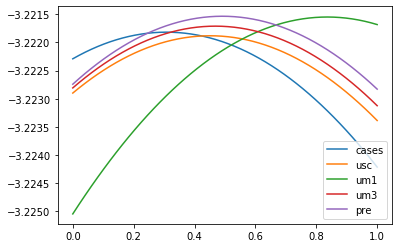

In [63]:
kernel_list(cases,'cases')
kernel_list(usc,'usc')
kernel_list(umich1,'um1')
kernel_list(umich3,'um3')
kernel_list(predicted,'pre')